In [1]:
import sys
sys.path += [".."]

import smbh
from math import *
import numpy as np
from scipy.special import erf
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

from glob import glob

# Sound speed

$$
    c_s = \sqrt{\dfrac{\gamma R}{\mathcal{M}_w}T_\text{vir}} = \sqrt{\dfrac{\gamma R}{\mathcal{M}_w}\left(\dfrac{\mu m_p G M_h}{2k_BR_\text{vir}}\right)} = \sqrt{\dfrac{\gamma R\mu m_pG}{2\mathcal{M}_wk_B}} \sqrt{\dfrac{M_h}{R_\text{vir}}} \approx 0.614 \sqrt{\dfrac{M_h}{R_\text{vir}}}\text{ kpcGyr$^{-1}$}
$$

In [2]:
from scipy.constants import m_p, k, R
smbh.SOLAR_MASSES * 1e5, m_p

mu = 1.1
gamma = 5 / 3

f = ((gamma * R * mu * m_p * smbh.G) / (2 * k * (mu / 1000)))
f = f ** 0.5
print(f, f * (1e3 / smbh.R_VIR_z20) ** 0.5)

0.6144932248516448 23.393807027602534


In [3]:
def soundSpeedChoksi(mh, z):
    kms = 1.8 * (1 + z) ** 0.5 * (mh / 100) ** (1/3) * (0.304 * (0.678 ** 2) / 0.14) ** (1 / 6)
    return smbh.kmsTokpcGyr(kms)

In [4]:
soundSpeedChoksi(1e3, 20)

18.169224634725687

# Mach function zero

$$
    \ln\Lambda\left[1.5\left(\erf{\dfrac{\mathcal{M}}{\sqrt{2}}} - \sqrt{\dfrac{2}{\pi}}\mathcal{M}e^{-\mathcal{M}^2/2}\right) - 1\right] - 0.5\ln\left(1 - \mathcal{M}^{-2}\right) = 0
$$

In [5]:
def mach(m, lnL = 2.3):
    factor = erf(m / sqrt(2)) - sqrt(2 / np.pi) * m * np.exp(-(m ** 2) / 2)
    f1 = 1.5 * lnL * factor
    f2 = 0.5 * np.log(1 - (m ** -2)) + lnL
    return f1 - f2

fsolve(mach, 1.7)

array([1.73100478])

# Scale length approx
$$
	\mathcal{R}_s = \dfrac{0.01}{\left(1 + \sqrt{2}\right)}\left({\dfrac{M_hG}{100 H(t)^2}}\right)^{1/3}
$$

In [6]:
a = 0.01 / (1 + sqrt(2)) * (smbh.G / 100) ** (1/3)
print("%e" % a)

6.837750e-04


# Density profiles

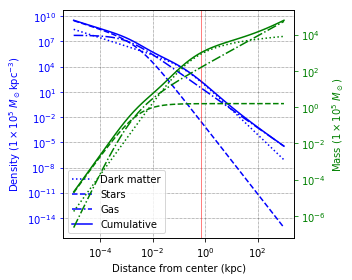

In [7]:
r = np.logspace(-5, 3)

smbh.setBaryonicFraction(0.156)
smbh.setGasPower(2.2)

smbh.setStellarRatio(0.01)
fig, axs = smbh.plotDensityMassForAll(r, figsize = (5, 4))
fig.savefig("density_mass_fs01.png", dpi = 300)

In [8]:
crit = 1.6726e-27 / (0.8751e-15) ** 3
crit

crit * (3.1875e19)**3 / 1.98847e35

4.064906664375494e+41

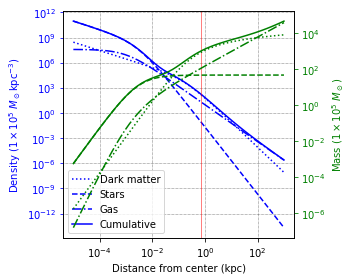

In [9]:
smbh.setStellarRatio(0.3)
fig, axs = smbh.plotDensityMassForAll(r, figsize = (5, 4))
fig.savefig("density_mass_fs3.png", dpi = 300)

# Single orbits

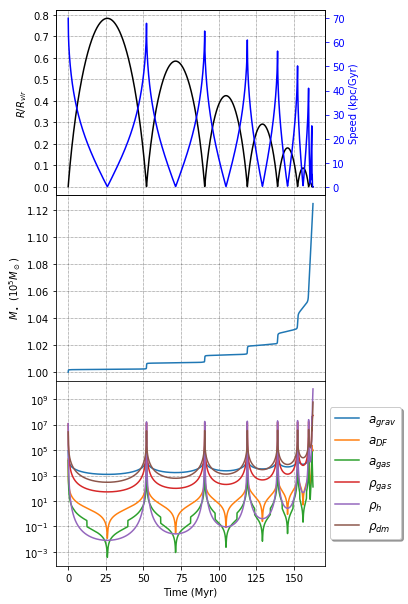

In [10]:
v0 = 70 # to kpc / gyr

smbh_m = 1

smbh.setStellarRatio(0.01)

result = smbh.run([v0, 0, 0], save_every = 10, pot_type = smbh.SYMMETRIC)

fig, (ax1, ax2, ax3) = smbh.plotProperties(result)

fig.savefig('properties_s02v70.png', dpi = 300)

plt.show()

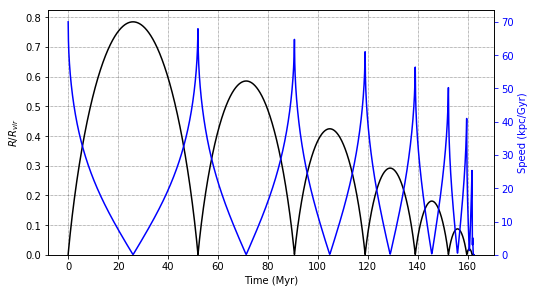

In [11]:
fig, ax1 = plt.subplots(figsize = (8, 4.5))

ax2 = ax1.twinx()
ax1.plot(result.times * 1000, result.distance / result.R_VIR, c = 'k')
ax2.plot(result.times * 1000, result.speed, c = 'b')

ax1.grid()

ax1.set_xlabel("Time (Myr)")
ax1.set_ylabel("$R / R_{vir}$")
ax2.set_ylabel("Speed (kpc/Gyr)", color = 'b')

ax1.tick_params('y', colors = 'k')
ax2.tick_params('y', colors = 'b')

ax1.set_ylim(0, ax1.get_ylim()[1])
ax2.set_ylim(0, ax2.get_ylim()[1])

fig.savefig('properties_s02v70_1.png', dpi = 300)

plt.show()

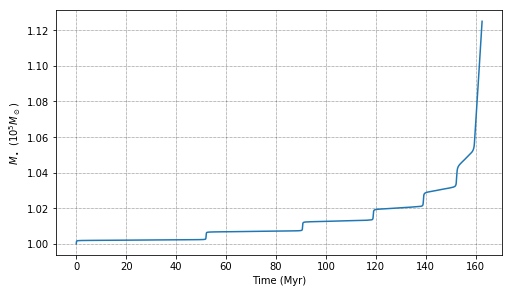

In [12]:
fig, ax1 = plt.subplots(figsize = (8, 4.5))

# ax2 = ax1.twinx()
ax1.plot(result.times * 1000, result.masses)

ax1.grid()

ax1.set_xlabel("Time (Myr)")
ax1.set_ylabel(r"$M_\bullet$ ($10^5M_\odot$)")

# ax1.set_ylim(0, ax1.get_ylim()[1])
# ax2.set_ylim(0, ax2.get_ylim()[1])

fig.savefig('properties_s02v70_2.png', dpi = 300)

plt.show()

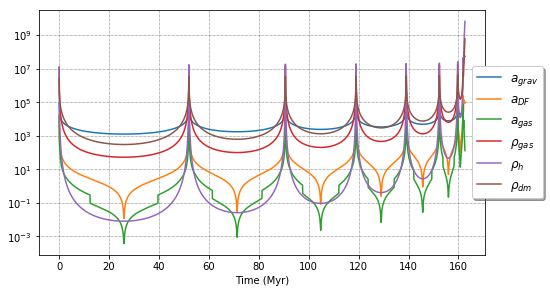

In [13]:
fig, ax1 = plt.subplots(figsize = (8, 4.5))

t = result.times * 1000
r = result.distance
v = result.speed

dm = smbh.dynamicalFrictionDM(r, v)
dg = smbh.dynamicalFrictionGas(r, v)
grav = smbh.gravitationalForce(r)
rho_dm = smbh.darkMatterDensity(r)
rho_h = smbh.stellarDensityHernquist(r)
rho_g = smbh.gasDensity(r)

ax1.plot(t, abs(grav), label = '$a_{grav}$')
ax1.plot(t, abs(dm), label = '$a_{DF}$')
ax1.plot(t, abs(dg), label = '$a_{gas}$')
ax1.plot(t, rho_g, label = r'$\rho_{gas}$')
ax1.plot(t, rho_h, label = r'$\rho_h$')
ax1.plot(t, rho_dm, label = r'$\rho_{dm}$')

ax1.grid()

ax1.set_xlabel("Time (Myr)")
ax1.set_yscale('log')

ax1.legend(loc = 'center', bbox_to_anchor = (1.05, 0.5),
          ncol = 1, fancybox = True, shadow = True, prop = {'size': 12})

fig.savefig('properties_s02v70_3.png', dpi = 300)

plt.show()

# Power law

In [14]:
v0 = 70 # to kpc / gyr

smbh_m = 1

smbh.setStellarRatio(0.01)

In [15]:
r = np.logspace(-5, 3)
powers = [1.8, 1.9, 2.1, 2.2, 2.3]

results = []
ds = []
ms = []

for power in powers:
    smbh.setGasPower(power)
    result = smbh.run([v0, 0, 0], pot_type = smbh.SYMMETRIC, save_every = 10)
    results.append(result)
    ds.append(smbh.gasDensity(r))
    ms.append(smbh.gasMass(r))

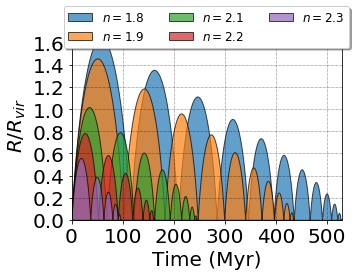

In [16]:
labels = ["$n = %.1f$" % n for n in powers]
fig, ax = smbh.plotOrbits(results)

smbh.changeFontSize(ax, fs = 20)
smbh.coolLegend(ax, labels, ncol = 3, fontsize = 0.6 * 20)

fig.tight_layout()

fig.savefig("power_law_slides.png", dpi = 300)
plt.show()

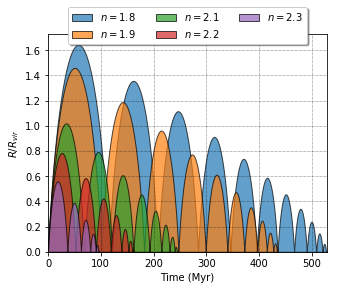

In [17]:
labels = ["$n = %.1f$" % n for n in powers]
fig, ax = smbh.plotOrbits(results)

smbh.coolLegend(ax, labels, ncol = 3)

fig.savefig("power_law.png", dpi = 300)
plt.show()

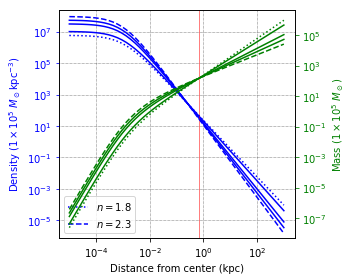

In [18]:
fig, (ax1, ax2) = smbh.plotDensityMass(r, ds[1:-1], ms[1:-1], lines = None, figsize = (5, 4))

ax1.plot(r, ds[0], ":", c = "b", label = "$n = %.1f$" % powers[0])
ax1.plot(r, ds[-1], "--", c = "b", label = "$n = %.1f$" % powers[-1])

ax2.plot(r, ms[0], ":", c = "g")
ax2.plot(r, ms[-1], "--", c = "g")

ax1.legend(loc = 3)

fig.savefig("power_law_density.png", dpi = 300)